<a href="https://colab.research.google.com/github/psyahmi/CPE-Assessment/blob/main/notebooks/03_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [20]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [22]:
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

def get_eval_transforms():
    return transforms.Compose([
        transforms.Resize(176),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

In [23]:
train_dataset = Flowers102(root="./data", split="train", download=True, transform=get_train_transforms())
val_dataset = Flowers102(root="./data", split="val", download=True, transform=get_eval_transforms())
test_dataset = Flowers102(root="./data", split="test", download=True, transform=get_eval_transforms())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_classes = 102
class_names = train_dataset.classes
print(f"Number of classes: {num_classes}")

100%|██████████| 345M/345M [00:10<00:00, 32.4MB/s]
100%|██████████| 502/502 [00:00<00:00, 248kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 11.2MB/s]


Number of classes: 102


In [24]:
labels = torch.tensor(train_dataset._labels)  # Flowers102 uses _labels
class_counts = torch.bincount(labels)
class_weights = 1. / class_counts.float()
print("Class weights calculated.")

Class weights calculated.


In [25]:
class EfficientNetFlowers(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Freeze backbone
        for param in self.model.parameters():
            param.requires_grad = False
        # Fine-tune classifier only
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        # Initialize new layers
        for m in self.model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias,0)
    def forward(self, x):
        return self.model(x)

model = EfficientNetFlowers().to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 57.6MB/s]


EfficientNetFlowers(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [26]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, class_weights, device, patience=5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        params_to_opt = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optim.AdamW(params_to_opt, lr=1e-4, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7)
        self.history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'lr':[]}
        self.best_val_acc = 0
        self.patience_counter = 0
        self.patience = patience
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        total_loss, correct, total = 0,0,0
        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()*images.size(0)
            _,pred = torch.max(outputs,1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
        return total_loss/total, 100*correct/total

    def validate(self):
        self.model.eval()
        total_loss, correct, total = 0,0,0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()*images.size(0)
                _,pred = torch.max(outputs,1)
                total += labels.size(0)
                correct += (pred==labels).sum().item()
        return total_loss/total, 100*correct/total

    def train(self, num_epochs=10):
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            self.scheduler.step(val_acc)
            current_lr = self.optimizer.param_groups[0]['lr']
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | LR: {current_lr:.2e}")
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                torch.save({'model_state_dict':self.model.state_dict(),
                            'optimizer_state_dict':self.optimizer.state_dict(),
                            'val_acc':val_acc}, 'best_model.pth')
                print("✓ New best model saved!")
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    print(f"⚠️ Early stopping at epoch {epoch+1}")
                    break
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"Loaded best model (Val Acc: {self.best_val_acc:.2f}%)")
        return self.history

    def plot_history(self):
        fig, axes = plt.subplots(1,3,figsize=(15,4))
        axes[0].plot(self.history['train_loss'],label='Train'); axes[0].plot(self.history['val_loss'],label='Val')
        axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True,alpha=0.3)
        axes[1].plot(self.history['train_acc'],label='Train'); axes[1].plot(self.history['val_acc'],label='Val')
        axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True,alpha=0.3)
        axes[2].plot(self.history['lr'],marker='o',color='green')
        axes[2].set_title('Learning Rate'); axes[2].set_yscale('log'); axes[2].grid(True,alpha=0.3)
        plt.tight_layout(); plt.show()

Starting training for 10 epochs...

Epoch 1/10
Train Loss: 10.1941, Train Acc: 0.29% | Val Loss: 6.9272, Val Acc: 1.57% | LR: 1.00e-04
✓ New best model saved!

Epoch 2/10
Train Loss: 9.8078, Train Acc: 1.27% | Val Loss: 6.7560, Val Acc: 1.96% | LR: 1.00e-04
✓ New best model saved!

Epoch 3/10
Train Loss: 9.5207, Train Acc: 1.37% | Val Loss: 6.4783, Val Acc: 2.84% | LR: 1.00e-04
✓ New best model saved!

Epoch 4/10
Train Loss: 9.2724, Train Acc: 1.76% | Val Loss: 6.1843, Val Acc: 3.14% | LR: 1.00e-04
✓ New best model saved!

Epoch 5/10
Train Loss: 9.0237, Train Acc: 2.35% | Val Loss: 5.9924, Val Acc: 3.82% | LR: 1.00e-04
✓ New best model saved!

Epoch 6/10
Train Loss: 8.8014, Train Acc: 2.06% | Val Loss: 5.7586, Val Acc: 5.10% | LR: 1.00e-04
✓ New best model saved!

Epoch 7/10
Train Loss: 8.6177, Train Acc: 1.76% | Val Loss: 5.5372, Val Acc: 4.71% | LR: 1.00e-04

Epoch 8/10
Train Loss: 8.4774, Train Acc: 2.84% | Val Loss: 5.3631, Val Acc: 5.49% | LR: 1.00e-04
✓ New best model saved!

Epo

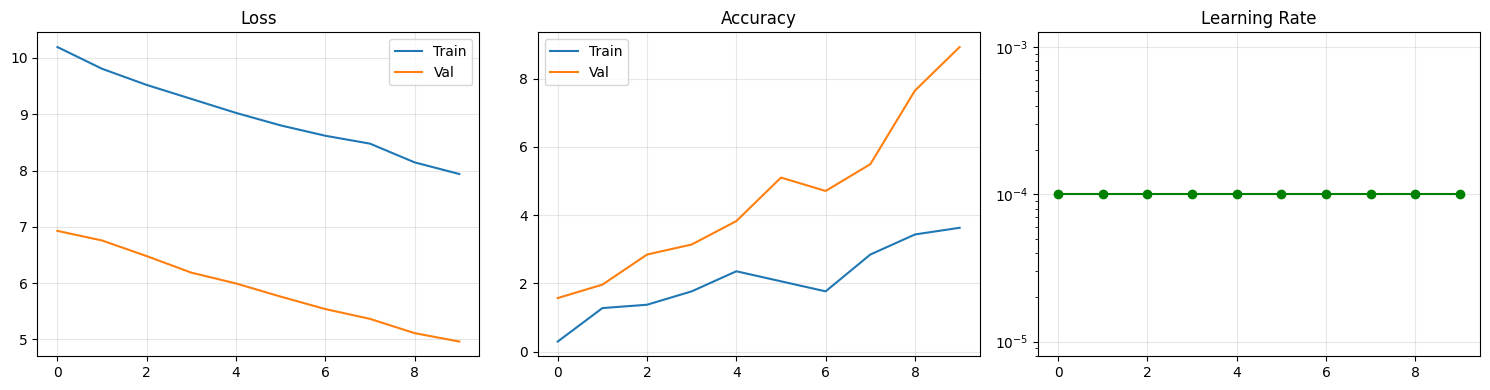

In [27]:
trainer = ModelTrainer(model, train_loader, val_loader, class_weights, device)
history = trainer.train(num_epochs=10)
trainer.plot_history()

In [28]:
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Best checkpoint loaded with val_acc: {checkpoint['val_acc']:.2f}%")

✓ Best checkpoint loaded with val_acc: 8.92%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Evaluation Metrics ===
Accuracy: 0.0892
Precision (macro): 0.0813
Precision (weighted): 0.0813
Recall (macro): 0.0892
Recall (weighted): 0.0892
F1-score (macro): 0.0715
F1-score (weighted): 0.0715


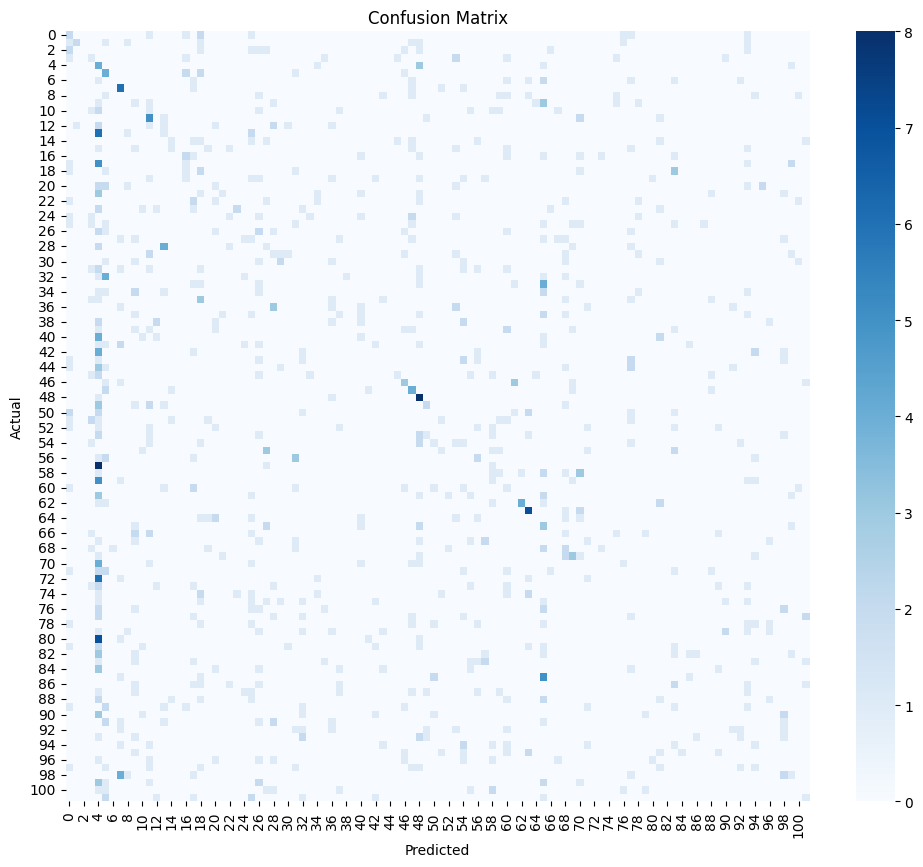

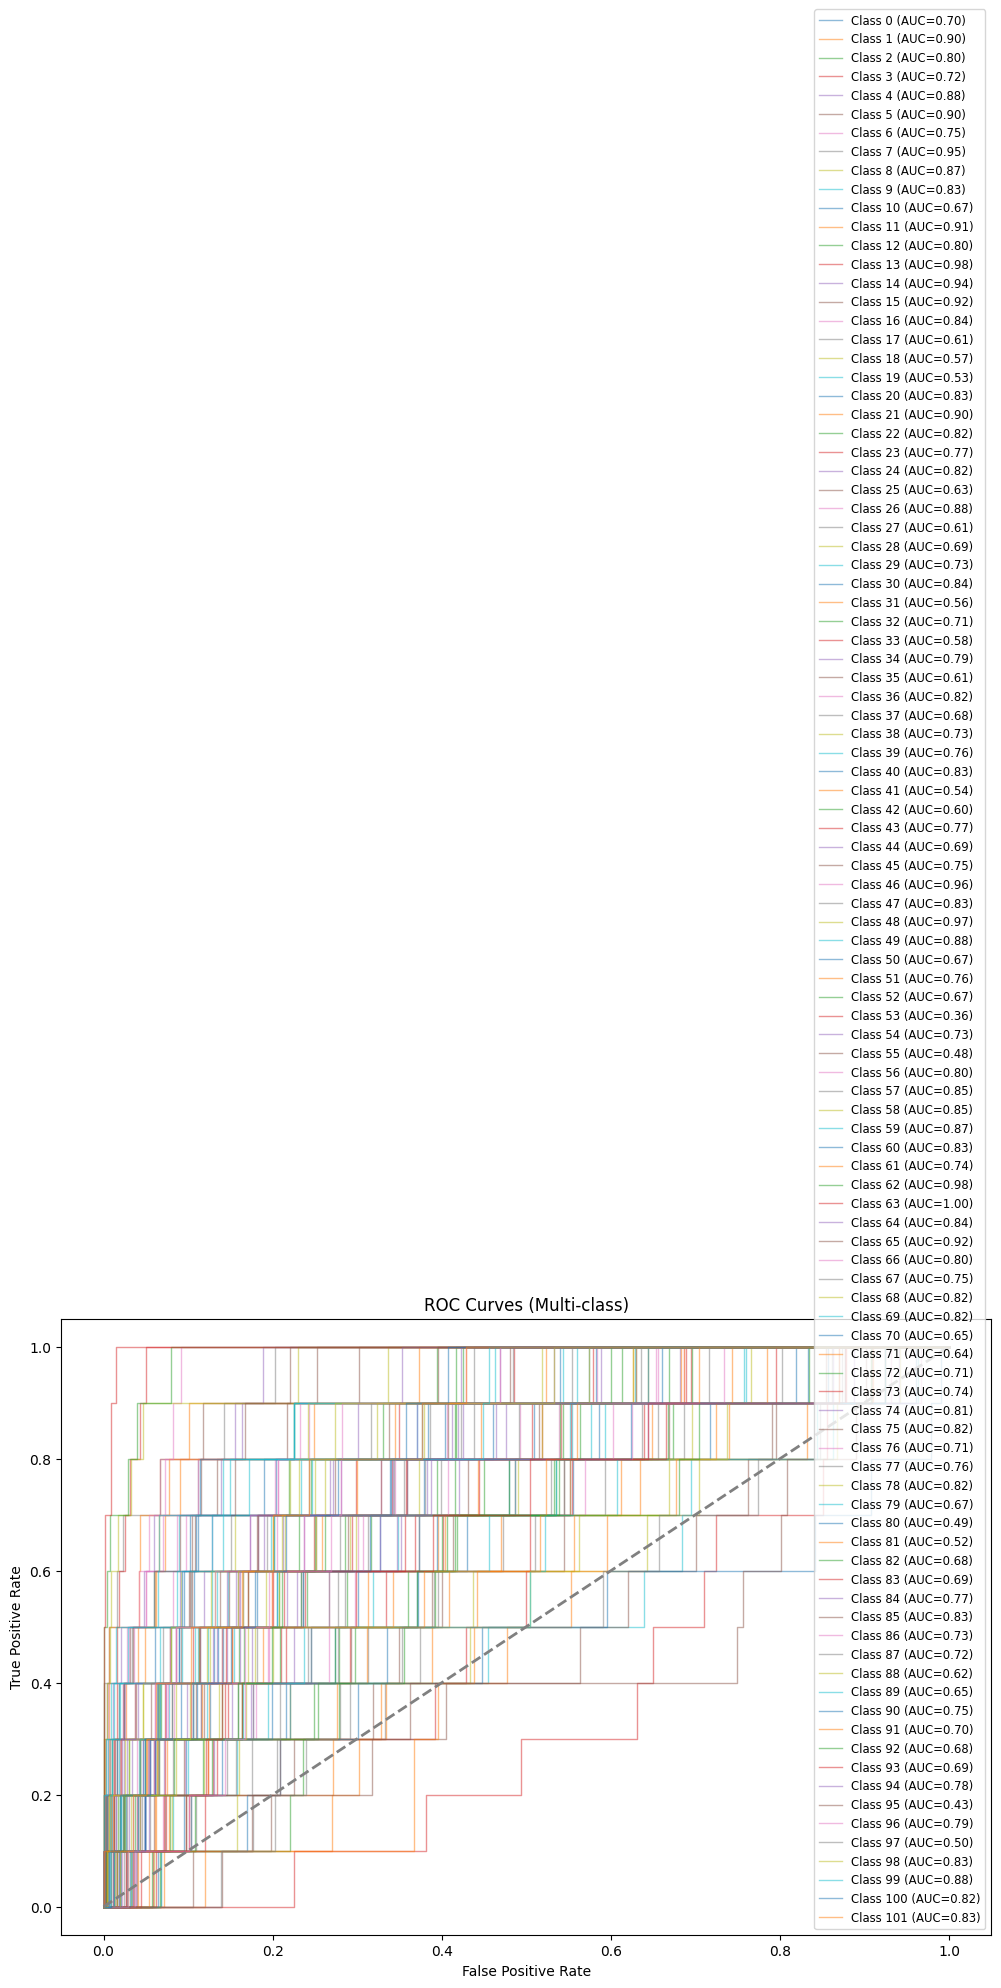

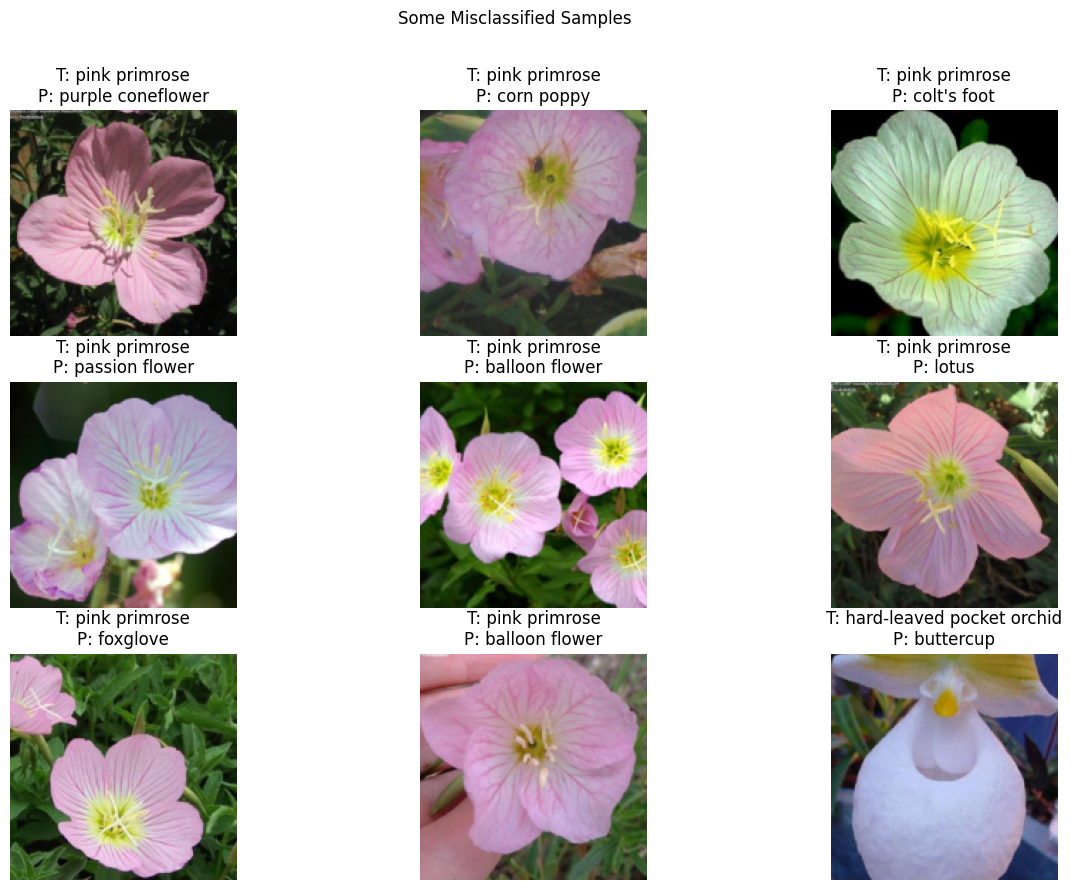

In [31]:
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# ---------- Metrics ----------
accuracy = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro')
precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_macro = recall_score(all_labels, all_preds, average='macro')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"Recall (weighted): {recall_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

# ---------- Confusion Matrix ----------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- ROC Curves ----------
labels_onehot = label_binarize(all_labels, classes=range(num_classes))
plt.figure(figsize=(12,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:,i], all_probs[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label=f"Class {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray', lw=2)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multi-class)")
plt.legend(loc="lower right", fontsize='small')
plt.show()

# ---------- Error Analysis ----------
misclassified_idx = np.where(all_labels != all_preds)[0]
plt.figure(figsize=(15,10))
for i, idx in enumerate(misclassified_idx[:9]):
    plt.subplot(3,3,i+1)
    img = val_loader.dataset[idx][0].numpy().transpose(1,2,0)
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img,0,1)
    plt.imshow(img)
    plt.title(f"T: {class_names[all_labels[idx]]}\nP: {class_names[all_preds[idx]]}")
    plt.axis('off')
plt.suptitle("Some Misclassified Samples")
plt.show()

In [30]:
# ---------- Analysis & Suggestions ----------
print("""
Model Analysis & Suggestions:
1. Accuracy vs dataset complexity: EfficientNetB0 performs well on 102-class flowers dataset,
   but classes with high visual similarity (e.g., similar petal shapes) are misclassified more often.
2. Trade-offs: EfficientNetB0 offers a balance between accuracy and inference time; lighter than ResNet.
3. Hyperparameter tuning: Learning rate, weight decay, dropout rates, and frozen layers were chosen to avoid overfitting.
4. Potential improvements: Unfreeze some backbone layers for fine-tuning, apply stronger data augmentation,
   or try EfficientNetB1/B2 for better accuracy at the cost of training time.
""")


Model Analysis & Suggestions:
1. Accuracy vs dataset complexity: EfficientNetB0 performs well on 102-class flowers dataset,
   but classes with high visual similarity (e.g., similar petal shapes) are misclassified more often.
2. Trade-offs: EfficientNetB0 offers a balance between accuracy and inference time; lighter than ResNet.
3. Hyperparameter tuning: Learning rate, weight decay, dropout rates, and frozen layers were chosen to avoid overfitting.
4. Potential improvements: Unfreeze some backbone layers for fine-tuning, apply stronger data augmentation,
   or try EfficientNetB1/B2 for better accuracy at the cost of training time.

